In [16]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [ ]:
## defining functions

In [2]:
def convert_to_datetime(date_str):
  new_date = datetime.strptime(date_str[4:24],"%b %d %Y %H:%M:%S")
  return new_date

def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)

    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)

    return total_return, apr, sharpe, maxDD, maxDDD 

In [21]:

import os
print(os.getcwd())


/Users/neha-finmath/Desktop/Quantinsider/STAT ARB PAIR TRADE


In [34]:
import yfinance as yf
import os


project_folder = "./Project_StatArb_US"
data_folder = os.path.join(project_folder, "data")
os.makedirs(data_folder, exist_ok=True)


tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "JPM", "XOM", "V", "JNJ", "PG","SPY"]


data = yf.download(tickers, start="2010-01-01", end="2025-01-01")


for ticker in tickers:
    try:
        ticker_data = data.xs(ticker, axis=1, level=1)
        file_path = os.path.join(data_folder, f"{ticker}_ohlcv.csv")
        ticker_data.to_csv(file_path)
        print(f"Saved {ticker} data to {file_path}")
    except KeyError:
        print(f"No data for {ticker}, skipping.")

/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_7357/2839794558.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  11 of 11 completed

Saved AAPL data to ./Project_StatArb_US/data/AAPL_ohlcv.csv
Saved MSFT data to ./Project_StatArb_US/data/MSFT_ohlcv.csv
Saved GOOGL data to ./Project_StatArb_US/data/GOOGL_ohlcv.csv
Saved AMZN data to ./Project_StatArb_US/data/AMZN_ohlcv.csv
Saved META data to ./Project_StatArb_US/data/META_ohlcv.csv
Saved JPM data to ./Project_StatArb_US/data/JPM_ohlcv.csv
Saved XOM data to ./Project_StatArb_US/data/XOM_ohlcv.csv
Saved V data to ./Project_StatArb_US/data/V_ohlcv.csv
Saved JNJ data to ./Project_StatArb_US/data/JNJ_ohlcv.csv
Saved PG data to ./Project_StatArb_US/data/PG_ohlcv.csv
Saved SPY data to ./Project_StatArb_US/data/SPY_ohlcv.csv


In [35]:
us_stocks = data  
us_stocks.head(2)

Price          Close                                                           \
Ticker          AAPL    AMZN      GOOGL        JNJ        JPM META       MSFT   
Date                                                                            
2010-01-04  6.418384  6.6950  15.576998  40.675068  28.552141  NaN  23.173346   
2010-01-05  6.429481  6.7345  15.508402  40.203426  29.105196  NaN  23.180828   

Price                                        ...     Volume             \
Ticker             PG        SPY          V  ...       AMZN      GOOGL   
Date                                         ...                         
2010-01-04  38.417023  85.279175  19.645655  ...  151998000   78169752   
2010-01-05  38.429611  85.504974  19.420538  ...  177038000  120067812   

Price                                                                        \
Ticker           JNJ       JPM META      MSFT       PG        SPY         V   
Date                                                                          
2010-01-04   9506200  35460500  NaN  38409100  9190800  118944600  20180000   
2010-01-05  10673100  41208300  NaN  49749600  8649400  111579900  25833600   

Price                 
Ticker           XOM  
Date                  
2010-01-04  27809100  
2010-01-05  30174700  

[2 rows x 55 columns]

In [ ]:
import pandas as pd


us_stock = pd.read_csv('./Project_StatArb_US/data/AAPL_ohlcv.csv')


us_stock['Date'] = pd.to_datetime(us_stock['Date'])


us_stock.set_index('Date', inplace=True)


us_stock.sort_index(inplace=True)


us_stock = us_stock['2020-12-29':'2024-01-29']


us_stock.rename(columns={'Close':'Price'}, inplace=True)


us_stock['daily_returns'] = us_stock['Price'].pct_change(periods=1)

us_stock.head()

,Price,High,Low,Open,Volume,daily_returns
Date,,,,,,
2020-12-29,131.289520,135.105452,130.773592,134.385107,121047300,NaN
2020-12-30,130.170013,132.379754,129.858502,131.980635,96452100,-0.008527
2020-12-31,129.167374,131.162954,128.223124,130.520472,99116600,-0.007703
2021-01-04,125.974449,130.062945,123.394799,129.975338,143301900,-0.024719
2021-01-05,127.531960,128.242590,125.020451,125.468246,97664900,0.012364


In [37]:
all_dfs = {}
for file in os.listdir(data_folder):
    if file.endswith("_ohlcv.csv"):
        ticker = file.split("_")[0]
        all_dfs[ticker] = pd.read_csv(os.path.join(data_folder, file))

In [38]:
all_dfs_copy = all_dfs
volume = pd.DataFrame(columns=list(all_dfs_copy.keys()))

start_date = datetime(2018, 3, 27)
end_date = datetime(2024, 1, 29)

for key in all_dfs_copy.keys():

    
    all_dfs_copy[key]['Date'] = pd.to_datetime(all_dfs_copy[key]['Date'])
   
    all_dfs_copy[key].set_index(all_dfs_copy[key]['Date'], inplace=True)
    all_dfs_copy[key].drop(columns=['Date'], inplace=True)
    
    
    all_dfs_copy[key].sort_index(inplace=True)
    
    
    all_dfs_copy[key] = all_dfs_copy[key]['2020-12-29':'2024-01-29']
    
    
    all_dfs_copy[key]['daily_returns'] = all_dfs_copy[key]['Close'].pct_change(periods=1)
    
   
    volume[key] = all_dfs_copy[key]['Volume']
    
    
    all_dfs_copy[key].drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True, errors='ignore')




In [39]:
dfs_is = dict()
dfs_os = dict()

for key in all_dfs_copy.keys():
    
    dfs_is[key] = all_dfs_copy[key]['2020-12-29':'2024-01-29']


In [40]:
df = pd.DataFrame(index=dfs_is[list(dfs_is.keys())[0]].index, columns=list(dfs_is.keys()))

for key in dfs_is.keys():
    df[key] = dfs_is[key]['daily_returns']


benchmark = pd.read_csv('./Project_StatArb_US/data/SPY_ohlcv.csv')
benchmark['Date'] = pd.to_datetime(benchmark['Date'])
benchmark.set_index('Date', inplace=True)
benchmark.sort_index(inplace=True)
benchmark = benchmark['2020-12-29':'2024-01-29']
df['SPY'] = benchmark['Close'].pct_change(periods=1)

# Drop rows with any NaNs
df.dropna(axis=0, inplace=True)

# Preview
print(df.head())


                MSFT      AMZN        PG       JPM     GOOGL       SPY  \
Date                                                                     
2020-12-30 -0.011019 -0.010882 -0.004696  0.002800 -0.012237  0.001427   
2020-12-31  0.003338 -0.008801  0.009944  0.013641  0.009440  0.005081   
2021-01-04 -0.021266 -0.021585 -0.009487 -0.009444 -0.015126 -0.013614   
2021-01-05  0.000965  0.010004  0.006385  0.005441  0.008064  0.006887   
2021-01-06 -0.025929 -0.024897  0.010527  0.046956 -0.009868  0.005979   

                META       XOM       JNJ      AAPL         V  
Date                                                          
2020-12-30 -0.017740  0.007996  0.012391 -0.008527  0.018613  
2020-12-31  0.004745 -0.009135  0.008523 -0.007703  0.001695  
2021-01-04 -0.015449  0.006793 -0.005591 -0.024719 -0.004435  
2021-01-05  0.007548  0.048193  0.011757  0.012364 -0.014925  
2021-01-06 -0.028269  0.025517  0.009410 -0.033661 -0.008811  


In [42]:
volume

,MSFT,AMZN,PG,JPM,GOOGL,SPY,META,XOM,JNJ,AAPL,V
Date,,,,,,,,,,,
2020-12-29,17403200,97458000,5139300,8389200,19726000,53680500,16383000.0,20287700,5212000,121047300,6093400
2020-12-30,20272300,64186000,3261400,7398000,21026000,49455300,11803800.0,23807300,5412800,96452100,8875100
2020-12-31,20942100,59144000,4076400,8580200,21070000,78520700,12900400.0,22786500,5099900,99116600,5922200
2021-01-04,37130100,88228000,8330900,16819900,37324000,110210800,15106100.0,27764700,11765900,143301900,10318300
2021-01-05,23823000,53110000,6856400,13731200,20360000,66426200,9871600.0,44035100,9602300,97664900,6869700
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-23,20525900,37986000,19101600,8360800,21636100,49945300,15506100.0,15863400,9149800,42355600,5883000
2024-01-24,24867000,48547300,11592700,9967100,25233500,81765000,15698500.0,17330600,7247900,53631300,5021700
2024-01-25,21021200,43638600,10352500,8873500,29149100,72525000,15091100.0,22089500,5478900,54822100,6894900


In [43]:
ret_n=pd.DataFrame()
for stock in df.columns:
  ret_n[stock] = (df[stock] - df[stock].mean())/df[stock].std()
df

,MSFT,AMZN,PG,JPM,GOOGL,SPY,META,XOM,JNJ,AAPL,V
Date,,,,,,,,,,,
2020-12-30,-0.011019,-0.010882,-0.004696,0.002800,-0.012237,0.001427,-0.017740,0.007996,0.012391,-0.008527,0.018613
2020-12-31,0.003338,-0.008801,0.009944,0.013641,0.009440,0.005081,0.004745,-0.009135,0.008523,-0.007703,0.001695
2021-01-04,-0.021266,-0.021585,-0.009487,-0.009444,-0.015126,-0.013614,-0.015449,0.006793,-0.005591,-0.024719,-0.004435
2021-01-05,0.000965,0.010004,0.006385,0.005441,0.008064,0.006887,0.007548,0.048193,0.011757,0.012364,-0.014925
2021-01-06,-0.025929,-0.024897,0.010527,0.046956,-0.009868,0.005979,-0.028269,0.025517,0.009410,-0.033661,-0.008811
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-23,0.006027,0.008011,0.041391,-0.006584,0.007192,0.002917,0.008958,0.011258,-0.016372,0.006653,0.000221
2024-01-24,0.009175,0.005448,-0.012080,0.008935,0.011289,0.001093,0.014278,0.017261,-0.005319,-0.003484,0.001438
2024-01-25,0.005738,0.005610,0.023008,0.014311,0.021318,0.005439,0.006348,0.025402,0.003774,-0.001697,0.003534


In [ ]:
##Correlation matrix calculation 

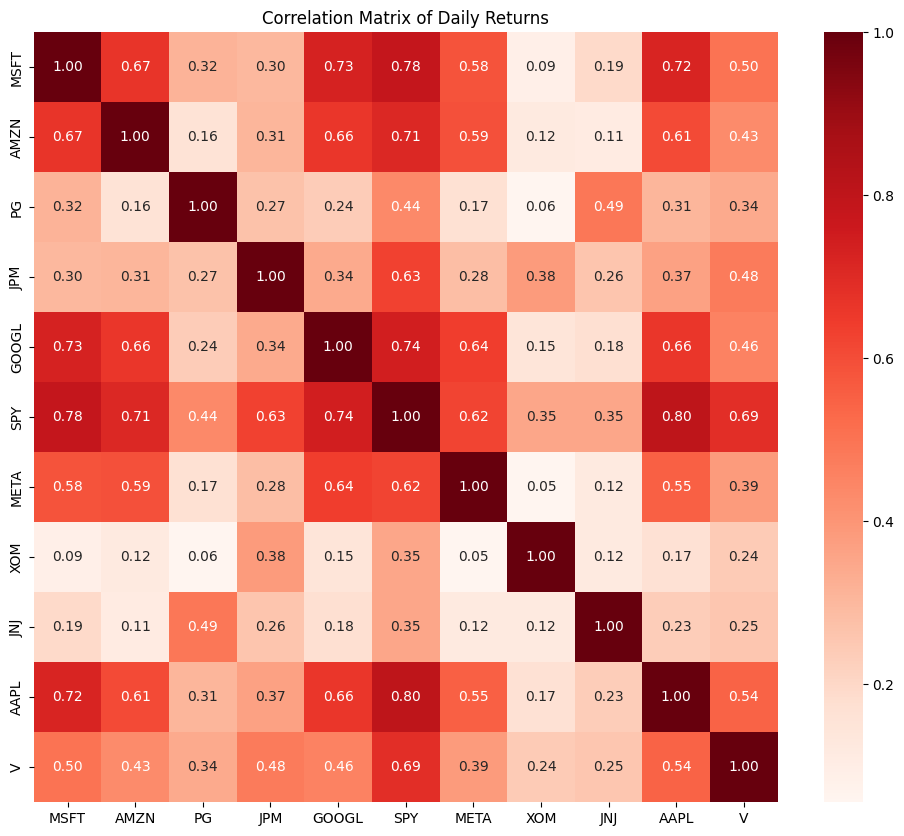

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt


stocks = df.columns  


corr_matrix = df.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="Reds", annot=True, fmt=".2f")
plt.title("Correlation Matrix of Daily Returns")
plt.show()

In [ ]:
#eigenvalue calculation 

In [45]:
eigen_val,eigen_vec = np.linalg.eig(ret_n[stocks].corr())
eigen_val = list(eigen_val)

In [46]:
np.sort(eigen_val)[::-1]

array([5.36987733, 1.46179846, 1.13033918, 0.6148775 , 0.54206341,
       0.47636943, 0.42921977, 0.36536121, 0.30568573, 0.24004511,
       0.06436287])

(0.0, 0.7)

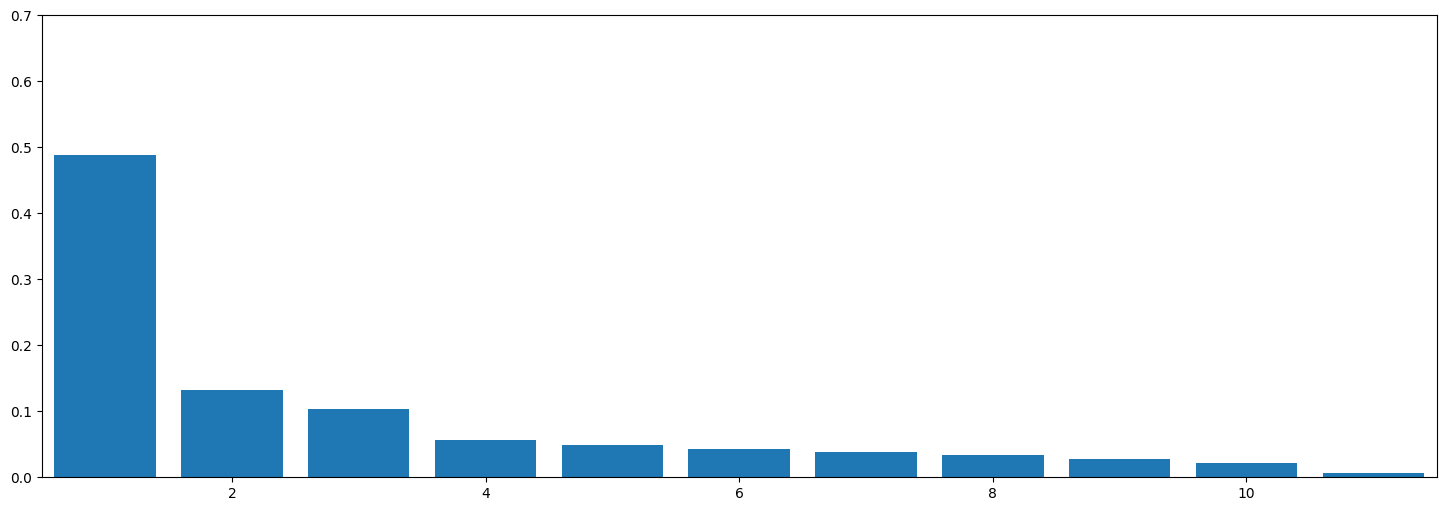

In [48]:
plt.figure(figsize=(18, 6))
plt.bar(
    np.arange(1, len(eigen_val) + 1),
    height=np.sort(eigen_val)[::-1] / sum(eigen_val)
)
plt.xlim(0.5, len(eigen_val) + 0.5)
plt.ylim(0, 0.7)

In [ ]:
#weight calculation through maximum eigenvalue 

In [49]:
weights = eigen_vec[:,eigen_val.index(max(eigen_val))]/df[stocks].std()
weights = weights/weights.sum()

In [ ]:
#cumulative daily returns (Daily buy and sell) 

In [55]:
stocks = df.columns  


ret_eig = np.cumprod((df[stocks] * weights).sum(axis=1) + 1)
benchmark = pd.read_csv('./Project_StatArb_US/data/SPY_ohlcv.csv')
benchmark['Date'] = pd.to_datetime(benchmark['Date'])
benchmark.set_index('Date', inplace=True)
benchmark.sort_index(inplace=True)
benchmark = benchmark['2020-12-29':'2024-01-29']
ret_index = np.cumprod(benchmark['Close'].pct_change().fillna(0) + 1)

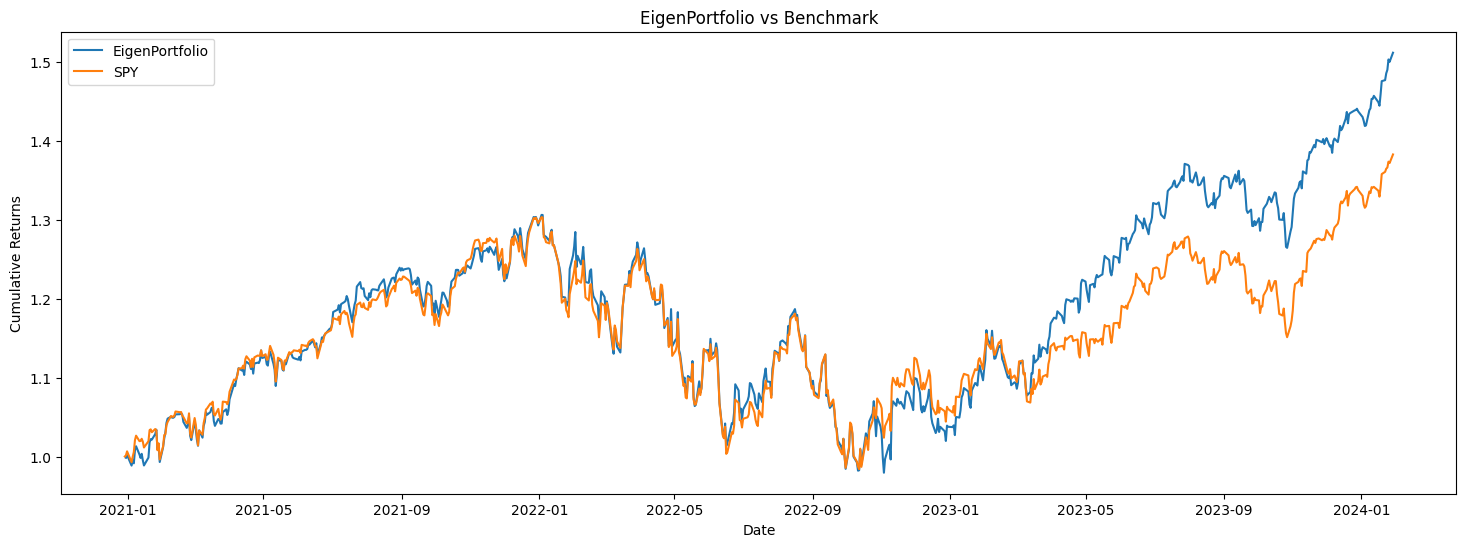

In [56]:
plt.figure(figsize=(18, 6))

# Plot portfolio cumulative returns
plt.plot(ret_eig, label='EigenPortfolio')

# Optional: add benchmark if available
plt.plot(ret_index, label='SPY')  

plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("EigenPortfolio vs Benchmark")
plt.legend()
plt.show()

In [66]:


def percentage_of_variance(returns, window, n=1):
    """
    returns: pd.DataFrame of daily returns
    window: rolling window size (number of days)
    n: number of top PCs to consider
    """
    explained_variance = []

    for t, dt in enumerate(returns.iloc[window-1:].index):
        tmp_ret = returns.loc[:dt].iloc[-window:]  # last 'window' days
        
        # Drop columns with all NaNs in the window
        tmp_ret = tmp_ret.dropna(axis=1, how='all')
        
        # Fill remaining NaNs with 0 (neutral daily return)
        tmp_ret = tmp_ret.fillna(0)
        
        # Compute eigenvalues
        evals = np.linalg.eig(tmp_ret.corr())[0]
        evals = np.sort(evals)[::-1]  # descending
        explained_variance.append(evals[:n].sum() / evals.sum())

    # Plot
    plt.figure(figsize=(18, 6))
    plt.plot(returns.iloc[window-1:].index, explained_variance, 
             label=f'Fraction of variance explained by top {n} PC(s)')
    plt.xlabel("Date")
    plt.ylabel("Fraction of Variance")
    plt.title("Fraction of Variance Explained by Top Principal Component(s)")
    plt.legend()
    plt.show()




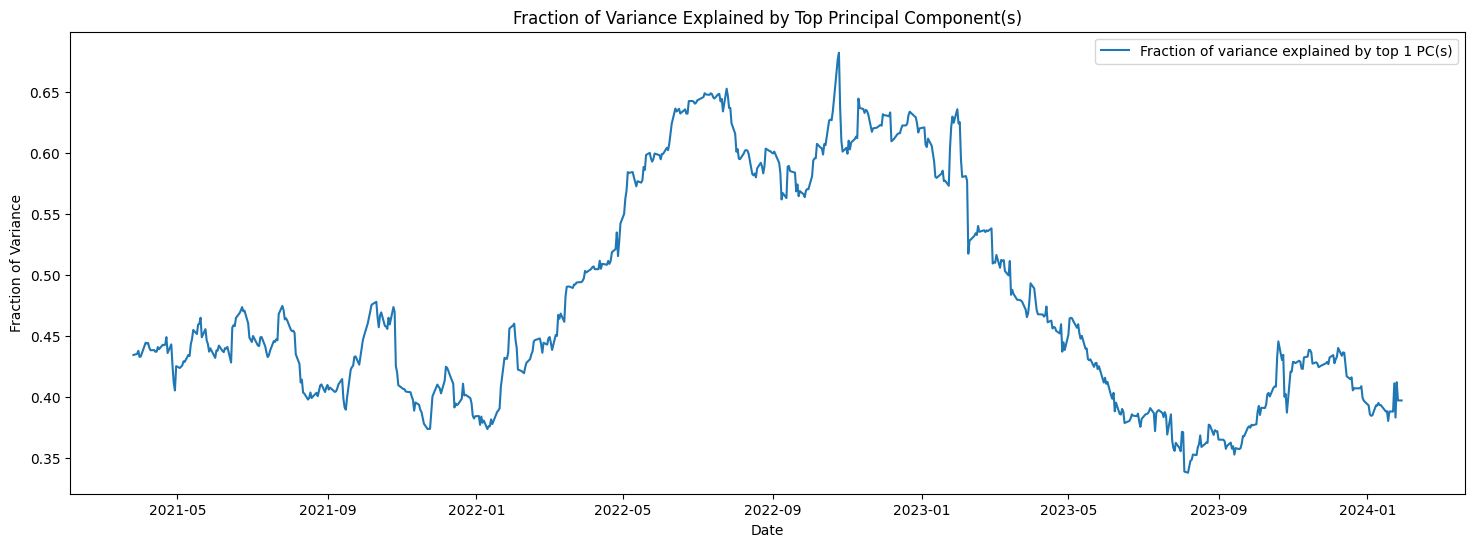

In [65]:
#fraction of variance explained by 1st PC
percentage_of_variance(df, window=60, n=1)

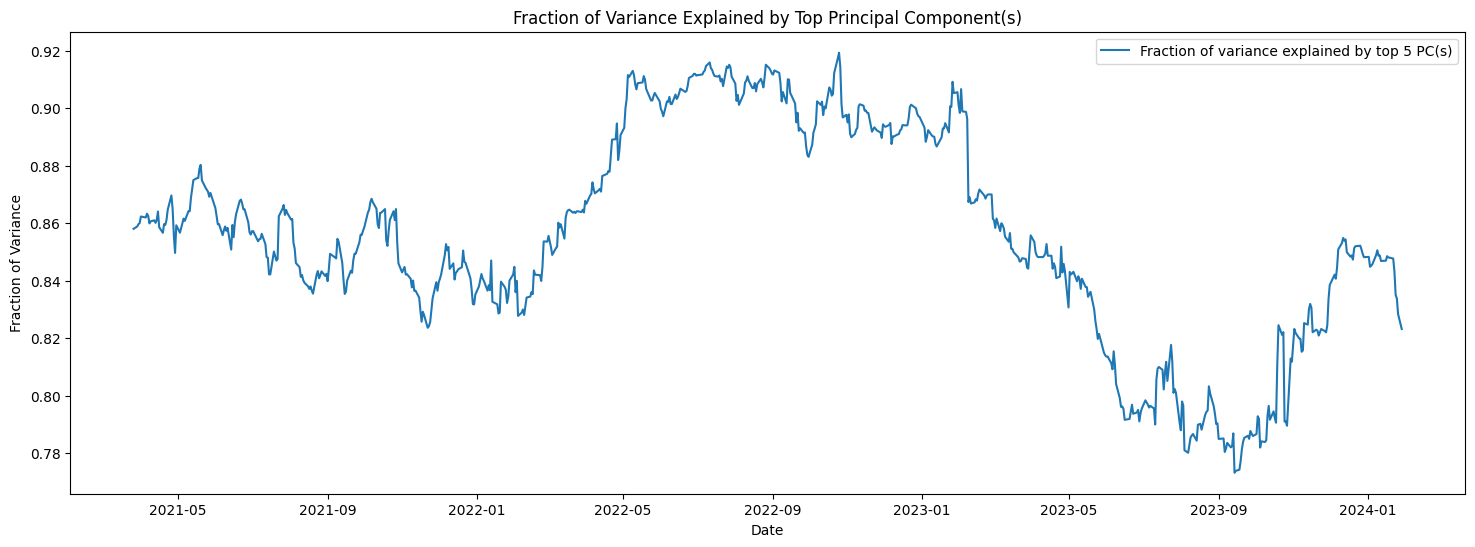

In [67]:
#fraction_of_variance explained by top 5 PCs
percentage_of_variance(df[stocks],60,5)

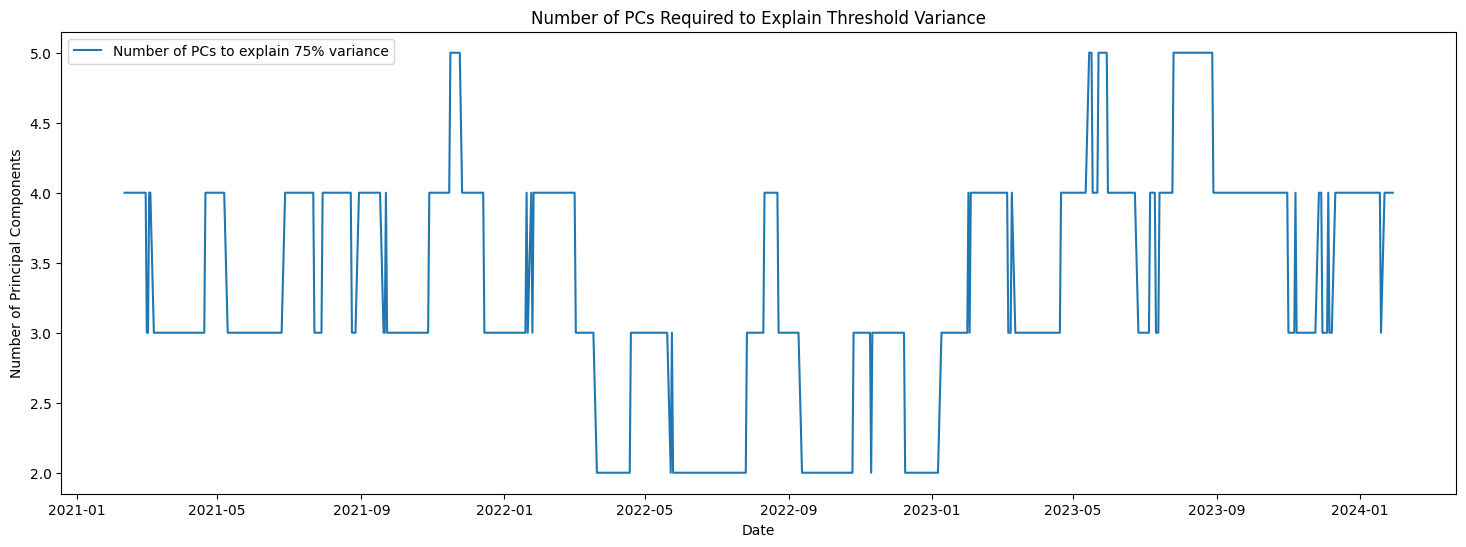

In [68]:


window = 30
thresh = 0.75

# Ensure stocks variable contains all tickers
stocks = df.columns  

# DataFrame to store number of PCs required
num_components = pd.DataFrame(index=df.iloc[window-1:].index, columns=['n_comp'])

for t, dt in enumerate(df.iloc[window-1:].index):
    tmp_ret = df[stocks].loc[:dt].iloc[-window:]  # last 'window' days
    
    # Drop columns with all NaNs in the window
    tmp_ret = tmp_ret.dropna(axis=1, how='all')
    
    # Fill remaining NaNs with 0
    tmp_ret = tmp_ret.fillna(0)
    
    # Compute eigenvalues
    evals = np.linalg.eig(tmp_ret.corr())[0]
    evals = np.sort(evals)[::-1]  # descending order
    
    # Fraction of variance explained
    explained_variance = evals / np.sum(evals)
    
    # Number of components required to reach threshold
    n_comp = np.where(np.cumsum(explained_variance) >= thresh)[0][0] + 1
    
    num_components.loc[dt, 'n_comp'] = n_comp  # use dt as index

# Plot
plt.figure(figsize=(18, 6))
plt.plot(num_components.index, num_components['n_comp'], label=f'Number of PCs to explain {thresh*100:.0f}% variance')
plt.xlabel("Date")
plt.ylabel("Number of Principal Components")
plt.title("Number of PCs Required to Explain Threshold Variance")
plt.legend()
plt.show()


In [1]:
#Correlation matrix of eigen

In [89]:
for i in range(1, 7):
    df[f'eig{i}'] = np.nan

window = 30

for t in df.iloc[window-1:].index:
    tmp_ret = df[stocks].loc[:t].iloc[-window:]  # last 30 days
    
    # Drop columns with all NaNs
    tmp_ret = tmp_ret.dropna(axis=1, how='all')
    
    if tmp_ret.shape[1] < 1:
        continue  # skip if no stocks available

    # Fill remaining NaNs with 0
    tmp_ret = tmp_ret.fillna(0)
    
    # Standardize returns safely (avoid division by zero)
    tmp_std = tmp_ret.std().replace(0, 1)  # replace 0 std with 1
    tmp_ret_std = (tmp_ret - tmp_ret.mean()) / tmp_std

    # Compute correlation matrix
    corr_mat = tmp_ret_std.corr()
    
    # Ensure symmetry
    corr_mat = (corr_mat + corr_mat.T) / 2
    
    # Compute eigenvalues and eigenvectors
    evals, evecs = np.linalg.eig(corr_mat.values)
    
    # Sort descending
    idx = np.argsort(evals)[::-1]
    
    for i in range(1, min(7, len(idx)+1)):  # handle less than 6 stocks
        weights = evecs[:, idx[i-1]] / tmp_std.values
        weights /= np.sum(np.abs(weights))  # normalize
        
        # Portfolio return for last day
        df.loc[t, f'eig{i}'] = np.real((weights * tmp_ret.iloc[-1].values).sum())

In [92]:
eig_df = df[['eig1','eig2','eig3','eig4','eig5','eig6']].iloc[window-1:]
eig_df = eig_df.applymap(lambda x: 0 if abs(x) < 1e-10 else x)
corr_matrix = eig_df.corr()
print(corr_matrix)


          eig1      eig2      eig3      eig4      eig5      eig6
eig1  1.000000  0.034487  0.174322  0.101036 -0.349835  0.026555
eig2  0.034487  1.000000 -0.160939 -0.321900  0.021993  0.117086
eig3  0.174322 -0.160939  1.000000  0.312354 -0.216013 -0.126879
eig4  0.101036 -0.321900  0.312354  1.000000 -0.401574 -0.532530
eig5 -0.349835  0.021993 -0.216013 -0.401574  1.000000  0.446258
eig6  0.026555  0.117086 -0.126879 -0.532530  0.446258  1.000000


/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_7357/1323789040.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  eig_df = eig_df.applymap(lambda x: 0 if abs(x) < 1e-10 else x)


In [96]:
window = 30

for t in df.iloc[window-1:].index:
    tmp_ret = df[stocks].loc[:t].iloc[-window:]  # last 30 days

    # Drop columns with all NaNs or constant values (variance = 0)
    tmp_ret = tmp_ret.dropna(axis=1, how='all')
    tmp_ret = tmp_ret.loc[:, tmp_ret.std() != 0]

    # Fill remaining NaNs with 0 or small number
    tmp_ret = tmp_ret.fillna(0)

    # Check if at least 2 columns remain to compute correlation
    if tmp_ret.shape[1] < 2:
        for i in range(1,7):
            df.loc[t, f'eig{i}'] = np.nan
        continue

    # Compute eigenvalues and eigenvectors
    evals, evecs = np.linalg.eig(tmp_ret.corr())

    # Sort eigenvalues descending
    index = np.argsort(evals)[::-1]

    for i in range(1, 7):
        weights = evecs[:, index[i-1]] / tmp_ret.std().values
        weights /= np.abs(weights).sum()
        val = np.dot(weights, tmp_ret.iloc[-1].values)
        df.loc[t, f'eig{i}'] = 0 if abs(val) < 1e-10 else val

/Users/neha-finmath/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/neha-finmath/Library/Python/3.9/lib/python/site-packages/pandas/core/internals/managers.py:1772: ComplexWarning: Casting complex values to real discards the imaginary part
  result[rl.indexer] = arr
/Users/neha-finmath/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/neha-finmath/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/neha-finmath/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:52: ComplexWa

/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_7357/3445401057.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  10 of 10 completed
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_7357/3445401057.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')  # fill missing values
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_7357/3445401057.py:87: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = np.sqrt(np.var(zeta)/(1-b**2)) if b**2 != 1 else np.nan
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_7357/3445401057.py:87: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = np.sqrt(np.var(zeta)/(1-b**2)) if b**2 != 1 else np.nan
/var/folders/zd/q7

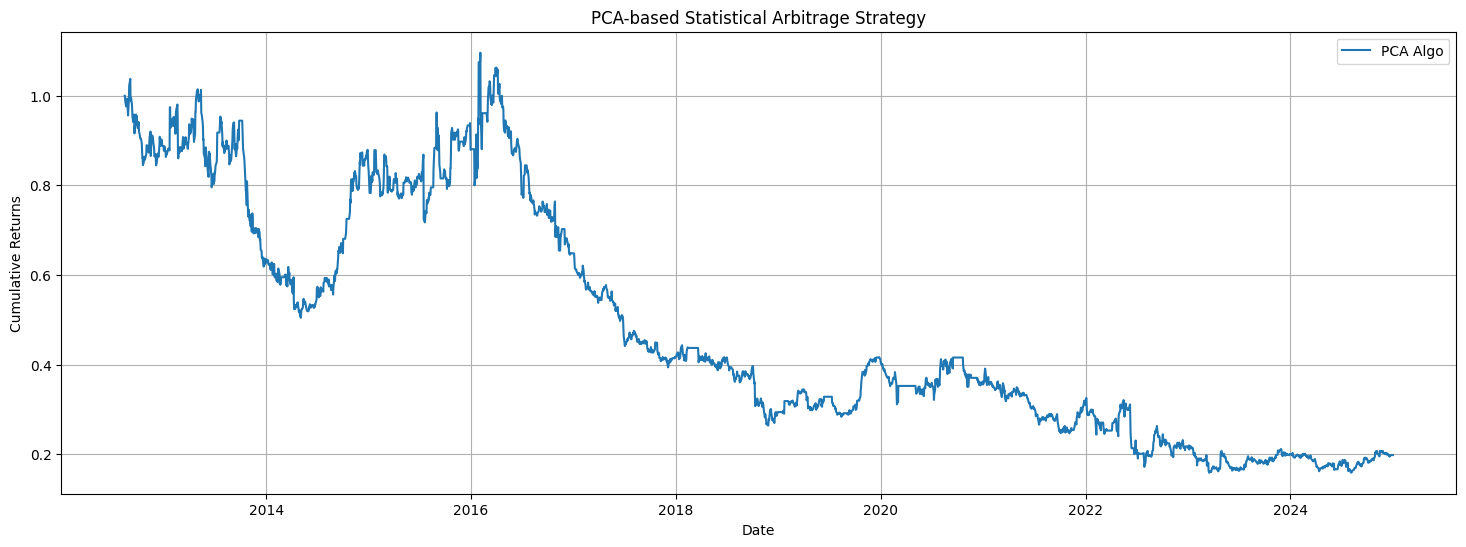

In [119]:
# ------------------------------
# Step 0: Imports
# ------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf

# ------------------------------
# Step 1: Download US stock data
# ------------------------------
tickers = ["AAPL","MSFT","GOOGL","AMZN","META","JPM","XOM","V","JNJ","PG"]
start_date = "2010-01-01"
end_date = "2025-01-01"

data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.fillna(method='ffill')  # fill missing values
returns = data.pct_change().dropna()

# ------------------------------
# Step 2: Compute eigenportfolios
# ------------------------------
def compute_eigenportfolios(returns, window=30, n_eig=6):
    df = returns.copy()
    stocks = df.columns
    for i in range(1, n_eig+1):
        df[f'eig{i}'] = np.nan

    for t in df.iloc[window-1:].index:
        tmp_ret = df.loc[:t, stocks].iloc[-window:]
        tmp_ret = tmp_ret.dropna(axis=1, how='all')
        tmp_ret = tmp_ret.fillna(0)

        evals, evecs = np.linalg.eig(tmp_ret.corr())
        index = np.argsort(evals)[::-1]

        for i in range(1, n_eig+1):
            weights = evecs[:, index[i-1]] / tmp_ret.std().values
            weights /= np.abs(weights).sum()  # normalize
            df.loc[t, f'eig{i}'] = np.real((weights * tmp_ret.iloc[-1].values).sum())
    return df

df = compute_eigenportfolios(returns)

# ------------------------------
# Step 3: PCA portfolio strategy
# ------------------------------
def n_pca_portfolio(modified_returns, returns, num_pc=1, l_win=60, s_win=30, benchmark='SPY'):
    stocks = list(returns.columns.drop([f'eig{i}' for i in range(1,7)]))
    
    s_scores = pd.DataFrame(index=returns.iloc[l_win:].index, columns=stocks)
    betas = pd.DataFrame(index=returns.iloc[l_win:].index, columns=stocks)
    
    pcs = [f'eig{i}' for i in range(1,7)]
    
    for t in modified_returns.index[l_win:]:
        tmp_ret = modified_returns.loc[:t].iloc[-s_win:]
        tmp_ret = (tmp_ret - tmp_ret.mean()) / tmp_ret.std()
        tmp_ret = tmp_ret.fillna(0)
        
        ou_params = pd.DataFrame(index=stocks, columns=['a','b','Var(zeta)','kappa','m','sigma','sigma_eq'])
        
        for stock in stocks:
            X = tmp_ret[pcs[:num_pc]].values
            y = tmp_ret[stock].values
            if np.isnan(y).any() or X.shape[1]==0:
                continue
            model1 = LinearRegression().fit(X, y)
            betas.loc[t, stock] = model1.coef_
            epsilon = y - model1.predict(X)

            # OU regression
            Xk = epsilon.cumsum()
            X_reg = Xk[:-1].reshape(-1,1)
            y_reg = Xk[1:]
            if len(y_reg) == 0:
                continue
            model2 = LinearRegression().fit(X_reg, y_reg)
            a = model2.intercept_
            b = model2.coef_[0]
            zeta = y_reg - model2.predict(X_reg)

            kappa = -np.log(b)*252 if b > 0 else np.nan
            m = a / (1-b) if b != 1 else np.nan
            sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2)) if b**2 != 1 else np.nan
            sigma_eq = np.sqrt(np.var(zeta)/(1-b**2)) if b**2 != 1 else np.nan
            
            if kappa > (252/30):
                ou_params.loc[stock] = [a,b,np.var(zeta),kappa,m,sigma,sigma_eq]
        
        ou_params = ou_params.dropna()
        if not ou_params.empty:
            ou_params['m_bar'] = (ou_params['a'] / (1-ou_params['b']) - ou_params['a'].mean()/(1-ou_params['b'].mean()))
            ou_params['s'] = -ou_params['m_bar']/ou_params['sigma_eq']
            s_scores.loc[t, ou_params.index] = ou_params['s']
    
    s_scores = s_scores.fillna(0)
    betas = betas.fillna(0)
    
    # Positions
    algo_pos = pd.DataFrame(index=s_scores.index, columns=stocks)
    for s in stocks:
        pos = 0
        for t in s_scores.index:
            score = s_scores.loc[t, s]
            if score > 1.25: pos = -1
            elif score < -1.25: pos = 1
            elif pos == -1 and score < 0.5: pos = 0
            elif pos == 1 and score > -0.5: pos = 0
            algo_pos.loc[t, s] = pos

    # Weights
    algo_weights = algo_pos.copy()
    for t in algo_weights.index:
        tmp = algo_weights.loc[t]
        if (tmp>0).sum()>0: tmp[tmp>0]/=(tmp>0).sum()
        if (tmp<0).sum()>0: tmp[tmp<0]/=(tmp<0).sum()
        algo_weights.loc[t] = tmp

    # Compute returns
    ret = (returns.iloc[l_win+1:] * algo_weights.shift().bfill()).sum(axis=1) / (abs(algo_weights.shift().bfill()).sum(axis=1)/2)
    ret = ret.fillna(0)
    cumret = np.cumprod(ret + 1)

    plt.figure(figsize=(18,6))
    plt.plot(cumret.index, cumret, label='PCA Algo')
    plt.grid(True)
    plt.title("PCA-based Statistical Arbitrage Strategy")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.show()

    return cumret, s_scores

cumret, s_scores = n_pca_portfolio(df, df, num_pc=1, l_win=60, s_win=30)

# ------------------------------
# Step 4: Metrics
# ------------------------------
def calculate_metrics(cumret):
    cumret_values = cumret.dropna().values
    total_return = (cumret_values[-1] - cumret_values[0])/cumret_values[0]
    apr = (1+total_return)**(252/len(cumret_values)) - 1
    rets = pd.Series(cumret_values).pct_change().fillna(0)
    sharpe = np.sqrt(252) * np.mean(rets) / np.std(rets)

    highwatermark = np.zeros(len(cumret_values))
    drawdown = np.zeros(len(cumret_values))
    drawdownduration = np.zeros(len(cumret_values))
    for t in range(1, len(cumret_values)):
        highwatermark[t] = max(highwatermark[t-1], cumret_values[t])
        drawdown[t] = cumret_values[t]/highwatermark[t]-1
        drawdownduration[t] = 0 if drawdown[t]==0 else drawdownduration[t-1]+1
    maxDD = np.min(drawdown)
    maxDDD = np.max(drawdownduration)

    return total_return, apr, sharpe, maxDD, maxDDD



In [120]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret)
print(total_return, apr, sharpe, maxDD, maxDDD)

-0.8019584392594915 -0.12281719773968802 -0.2450335860973455 -0.8552645092335759 2241.0


In [121]:
print(df[['eig1','eig2','eig3']].describe())

Ticker         eig1         eig2         eig3
count   3145.000000  3145.000000  3145.000000
mean       0.000099     0.000053    -0.000012
std        0.011339     0.006848     0.005557
min       -0.100917    -0.046074    -0.029783
25%       -0.005457    -0.003464    -0.003081
50%        0.000028     0.000077     0.000077
75%        0.005732     0.003438     0.002948
max        0.098592     0.066396     0.031657


/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_7357/1621336097.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  11 of 11 completed
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_7357/1621336097.py:99: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = np.sqrt(np.var(zeta) / (1 - b**2)) if b**2 != 1 else np.nan
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_7357/1621336097.py:110: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  s_scores = s_scores.fillna(0)
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_7357/1621336097.py:140: FutureWarning: Downcasting object 

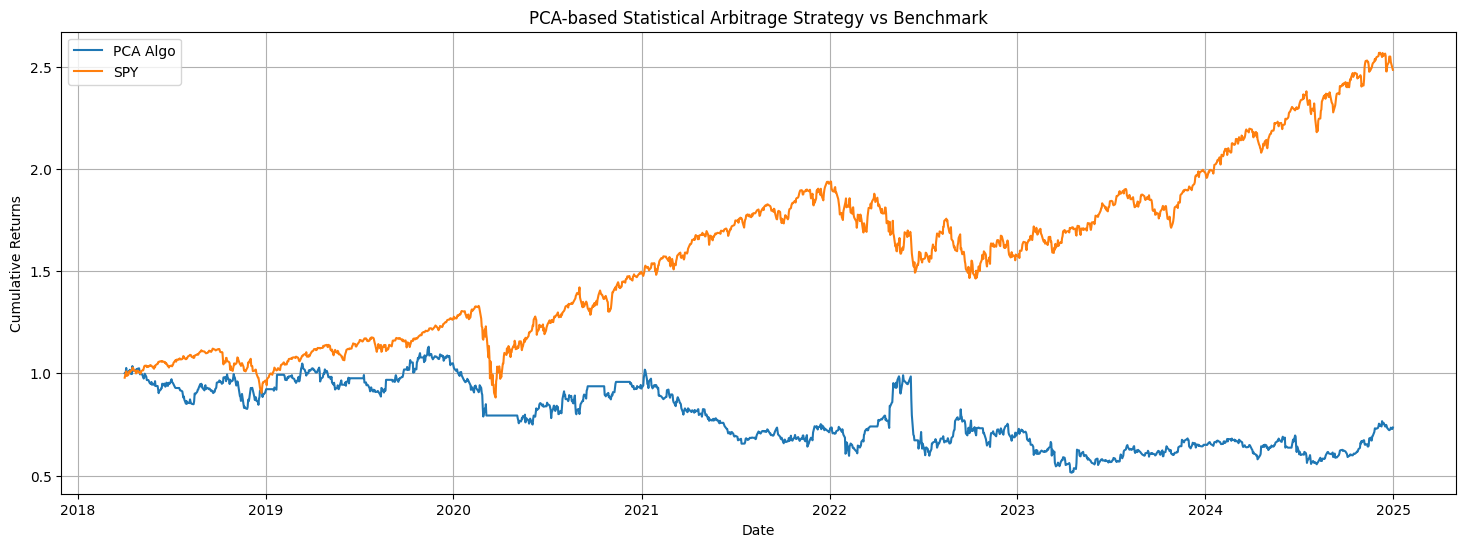

Total Return: -0.2653595969699343
APR: -0.044682881522848494
Sharpe Ratio: 0.004848264943469782
Max Drawdown: -0.545412306437232
Max Drawdown Duration: 1289.0


In [129]:
# ------------------------------
# Step 0: Imports
# ------------------------------
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime

# ------------------------------
# Step 1: Download US stock data
# ------------------------------
project_folder = "./Project_StatArb_US"
data_folder = project_folder + "/data"

import os
os.makedirs(data_folder, exist_ok=True)

# Example tickers; replace/add as needed
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "JPM", "XOM", "V", "JNJ", "PG", "SPY"]

# Download data
data = yf.download(tickers, start="2018-01-01", end="2025-01-01")
# Keep only 'Close' prices
price_data = data['Close'].copy()
price_data.to_csv(os.path.join(data_folder, "US_Stocks_Close.csv"))

# ------------------------------
# Step 2: Compute daily returns
# ------------------------------
returns = price_data.pct_change().dropna()
returns = returns.rename_axis("Date")

# ------------------------------
# Step 3: Compute eigenportfolios
# ------------------------------
def compute_eigenportfolios(df, stocks, window=30, n_eig=6):
    df = df.copy()
    for i in range(1, n_eig + 1):
        df[f'eig{i}'] = np.nan

    for t in df.index[window-1:]:
        tmp_ret = df[stocks].loc[:t].iloc[-window:]
        tmp_ret = tmp_ret.dropna(axis=1, how='all')
        tmp_ret = tmp_ret.fillna(0)
        evals, evecs = np.linalg.eig(tmp_ret.corr())
        index = np.argsort(evals)[::-1]

        for i in range(1, n_eig + 1):
            weights = evecs[:, index[i-1]] / tmp_ret.std().values
            weights /= np.abs(weights).sum()
            df.loc[t, f'eig{i}'] = np.real((weights * tmp_ret.iloc[-1].values).sum())
    return df

stocks = tickers.copy()
stocks.remove("SPY")  # remove benchmark from stock universe
df_with_eig = compute_eigenportfolios(returns, stocks)

# ------------------------------
# Step 4: PCA-based strategy
# ------------------------------
def n_pca_portfolio(modified_returns, returns, num_pc=3, l_win=60, s_win=30, benchmark='SPY'):
    stocks = list(returns.columns.drop([f'eig{i}' for i in range(1,7)] + [benchmark]))
    s_scores = pd.DataFrame(index=returns.iloc[l_win:].index, columns=stocks)
    betas = pd.DataFrame(index=returns.iloc[l_win:].index, columns=stocks)
    pcs = [f'eig{i}' for i in range(1,7)]

    for t in modified_returns.index[l_win:]:
        tmp_ret = modified_returns.loc[:t].iloc[-s_win:]
        tmp_ret = (tmp_ret - tmp_ret.mean()) / tmp_ret.std()
        tmp_ret = tmp_ret.fillna(0)

        ou_params = pd.DataFrame(index=stocks, columns=['a','b','Var(zeta)','kappa','m','sigma','sigma_eq'])

        for stock in stocks:
            X = tmp_ret[pcs[:num_pc]].values
            y = tmp_ret[stock].values
            if X.shape[1] < 1 or np.isnan(y).any():
                continue
            model1 = LinearRegression().fit(X, y)
            betas.loc[t, stock] = model1.coef_
            epsilon = y - model1.predict(X)

            # OU regression
            Xk = epsilon.cumsum()
            X_reg = Xk[:-1].reshape(-1,1)
            y_reg = Xk[1:]
            if len(X_reg) < 2:
                continue
            model2 = LinearRegression().fit(X_reg, y_reg)
            a = model2.intercept_
            b = model2.coef_[0]
            zeta = y_reg - model2.predict(X_reg)

            kappa = -np.log(b) * 252 if b > 0 else np.nan
            m = a / (1 - b) if b != 1 else np.nan
            sigma = np.sqrt(np.var(zeta) * 2 * kappa / (1 - b**2)) if b**2 != 1 else np.nan
            sigma_eq = np.sqrt(np.var(zeta) / (1 - b**2)) if b**2 != 1 else np.nan

            if kappa > (252/30):
                ou_params.loc[stock] = [a, b, np.var(zeta), kappa, m, sigma, sigma_eq]

        ou_params = ou_params.dropna()
        if not ou_params.empty:
            ou_params['m_bar'] = (ou_params['a'] / (1 - ou_params['b']) - ou_params['a'].mean() / (1 - ou_params['b'].mean()))
            ou_params['s'] = -ou_params['m_bar'] / ou_params['sigma_eq']
            s_scores.loc[t, ou_params.index] = ou_params['s']

    s_scores = s_scores.fillna(0)
    betas = betas.fillna(0)

    # Positions
    algo_pos = pd.DataFrame(index=s_scores.index, columns=stocks)
    for s in stocks:
        pos = 0
        for t in s_scores.index:
            score = s_scores.loc[t, s]
            if score > 1.25:
                pos = -1
            elif score < -1.25:
                pos = 1
            elif pos == -1 and score < 0.5:
                pos = 0
            elif pos == 1 and score > -0.5:
                pos = 0
            algo_pos.loc[t, s] = pos

    # Weights
    algo_weights = algo_pos.copy()
    for t in algo_weights.index:
        tmp = algo_weights.loc[t]
        if (tmp > 0).sum() > 0:
            tmp[tmp>0] /= (tmp>0).sum()
        if (tmp < 0).sum() > 0:
            tmp[tmp<0] /= (tmp<0).sum()
        algo_weights.loc[t] = tmp

    # Incorporate PCA portfolio positions
    algo_weights[pcs[:num_pc]] = (-np.stack((betas.values * algo_weights.shift().bfill().values).sum(axis=1)).reshape(-1,num_pc))

    # Compute returns
    ret = (returns.iloc[l_win+1:] * algo_weights.shift().bfill()).sum(axis=1) / (abs(algo_weights.shift().bfill()).sum(axis=1)/2)
    ret = ret.fillna(0)
    cumret = np.cumprod(ret+1)

    # Plot
    plt.figure(figsize=(18,6))
    plt.grid(True)
    plt.plot(cumret.index, cumret, label='PCA Algo')

    if benchmark in returns.columns:
        benchmark_cumret = np.cumprod(returns[benchmark].loc[cumret.index] + 1)
        plt.plot(cumret.index, benchmark_cumret, label=benchmark)

    plt.title("PCA-based Statistical Arbitrage Strategy vs Benchmark")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.show()

    return cumret, s_scores

# ------------------------------
# Step 5: Run PCA strategy
# ------------------------------
cumret, s_scores = n_pca_portfolio(df_with_eig, df_with_eig, num_pc=1, l_win=60, s_win=30, benchmark='SPY')

# ------------------------------
# Step 6: Performance Metrics
# ------------------------------
def calculate_metrics(cumret):
    cumret = cumret.values if isinstance(cumret, pd.Series) else cumret
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.Series(cumret).pct_change().fillna(0)
    sharpe = np.sqrt(252) * np.mean(rets) / np.std(rets)

    # Max Drawdown
    highwatermark = np.maximum.accumulate(cumret)
    drawdown = cumret/highwatermark - 1
    drawdownduration = np.zeros(len(cumret))
    duration = 0
    for i, dd in enumerate(drawdown):
        if dd < 0:
            duration += 1
        else:
            duration = 0
        drawdownduration[i] = duration
    maxDD = np.min(drawdown)
    maxDDD = np.max(drawdownduration)
    return total_return, apr, sharpe, maxDD, maxDDD

total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret)
print("Total Return:", total_return)
print("APR:", apr)
print("Sharpe Ratio:", sharpe)
print("Max Drawdown:", maxDD)
print("Max Drawdown Duration:", maxDDD)